In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [10, 5]


In [2]:
def calStability(raw, task_order, method):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:                
            target = rows[rows["method"]==m]
            _m = target[target["task_index"]==1][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            if m=="offline":
                continue
                
            
            _ideal = offline[offline["task_index"]==1]["accuracy"]
            val = float((_m["accuracy"]/float(_ideal)).sum()/len(_m))
            values[m].append(val)
    
    return values

In [22]:
def calPlasticity(raw, task_order, method):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            _sum = 0.0
                
            target = rows[rows["method"]==m]
            train_session = target["train_session"].unique()
            
            if m=="offline":
                continue
    
            _m = target[target["train_session"]==(target["task_index"])][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            _ideal = offline["accuracy"]
            
            if len(_m) != len(_ideal):
                values[m].append(np.nan)
                continue
            
            val = _m["accuracy"].div(_ideal.values, axis=0).sum()/len(_m)
            
            values[m].append(val)
            
    
    return values

In [23]:
def calOverallAcc(raw, task_order, method):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            if m=="offline":
                continue
                    
            _sum = 0.0
                
            target = rows[rows["method"]==m]
            
            task_index = target["task_index"].unique()
            train_session = target["train_session"].unique()
            
            _m = target[target["train_session"]==len(task_index)][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            _ideal = offline["accuracy"]
            
            if len(_m) != len(_ideal):
#                 print("SKIP", m, t)
                values[m].append(np.nan)
                continue
                
            val = _m["accuracy"].div(_ideal.values, axis=0).sum()/len(_m)
            values[m].append(val)
            
    return values

In [25]:
all_values = {}
for d in ["HouseA", "CASAS", "PAMAP", "DSADS"]:
# for d in ["CASAS"]:
    dataset = d
    folder = "../../Results/"+dataset+"/exp_component_sensitivity/"
    
    raw = pd.read_csv(folder+"results.txt")
    raw.columns = [c.strip() for c in raw.columns]
    raw["train_session"] = pd.to_numeric(raw["train_session"], errors='coerce')
    
    cmd = raw["cmd"].unique()
    task_order = raw["task_order"].unique()
    method = raw["method"].unique()

    stability = []
    plasticity = []
    overallAcc = []

    for c in cmd:
       
        target = raw[raw["cmd"]==c]
        m = calStability(target, task_order, method)
        stability.append(m)
        
        m = calPlasticity(target, task_order, method)
        plasticity.append(m)
        
        m = calOverallAcc(target, task_order, method)
        overallAcc.append(m)
        
    all_values[d] = (stability, plasticity, overallAcc)
    print(d, "DONE")

HouseA DONE
CASAS DONE
PAMAP DONE
DSADS DONE


# Plots

In [84]:
from scipy import stats

def plot(values, title, width=0.85, offset_ratio=0, xticks=[], models=None, rotation=-45):
    
    plt.rcParams['figure.figsize'] = [10, 8]
    
    m = [] 
    merr = []
    if models is None:
        models = ["mp-gan", "mp-wgan", "sg-cgan", "sg-cwgan"]

    # values[cmd]["sg-cgan"][task_order]
    for model in models:
        
        tmp = []
        tmperr = []
        for i, v in enumerate(values):
            avg = np.nanmean(v[model])
            err = stats.sem(v[model], nan_policy="omit")
            tmp.append(avg)
            tmperr.append(err)
        
        m.append(tmp)
        merr.append(tmperr)
    
    # m[model_index][cmd]
    print(m[0])
    print(merr[0])
    ind = np.arange(len(xticks)) # the x locations for the groups

    fig, ax = plt.subplots()
    
    patterns = [ "/" , "\\" , "x" , "-" , "+" , "|", "o", "O", ".", "*" ]
    for i, model in enumerate(models):
        offset = (float(i)/len(models))*width
        offset -= (offset_ratio)*width
        ax.bar(ind + offset, m[i], width*(1.0/len(models)), yerr=merr[i], label=model, hatch=patterns[i])
        
        X = np.arange(-0.5, len(m[0])+0.5)
        Y = [m[i][0] for _ in range(len(X))]
        ax.plot(X, Y, linestyle=':')

    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(xticks, rotation=rotation, rotation_mode="default", fontdict={"fontsize":20})
#     ax.legend()

    fig.tight_layout()

    plt.show()
    

In [85]:
xticks = [
    "no extra components",
    "self-verify",
    "oversampling",
    "regularization [EWC]",
    "regularization [KD]",
    "instance noise",
    "all"
]

[0.9039220261416535, 0.9132225030891894, 0.9039220261416535, 0.9585358371342412, 0.9712626426202011, 0.8967785383066424, 0.9461499177997258]
[0.054266170321848696, 0.045085395261991276, 0.054266170321848696, 0.03327777869594402, 0.03402070041829345, 0.06475316288814596, 0.04641769841274291]


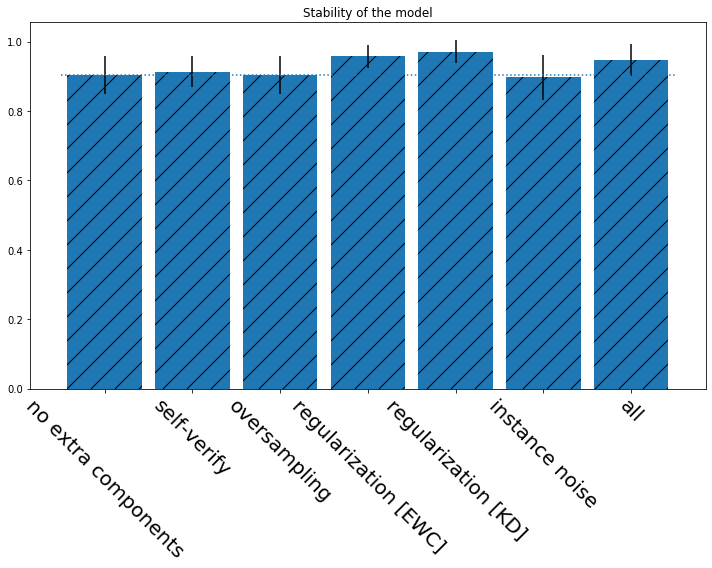

[1.1233467412535842, 1.1172861351929781, 1.1233467412535842, 1.1109022140583076, 1.0607630857084682, 1.120191934805226, 1.0269990207046351]
[0.020812894615621285, 0.019441043655844075, 0.020812894615621285, 0.021533844371913222, 0.0190535282514743, 0.018238148114186236, 0.022437347379182477]


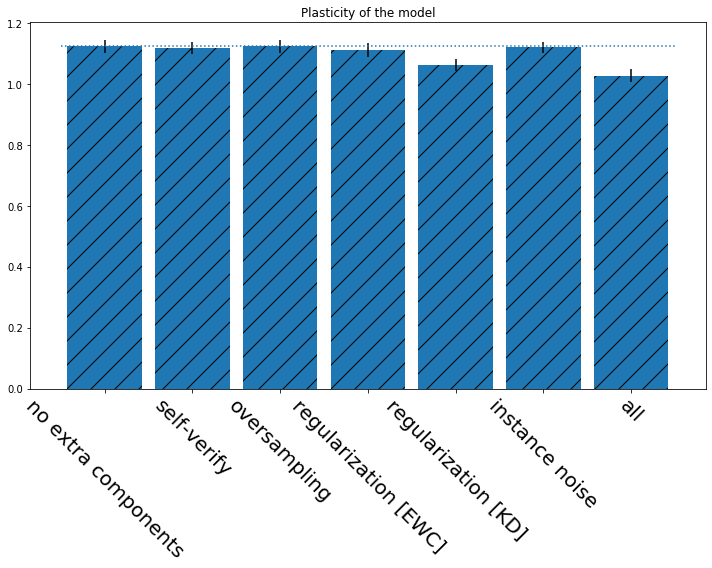

[0.8410251911197371, 0.8533559710975759, 0.8410251911197371, 0.8740820178795324, 0.8671510211299734, 0.8207119556922997, 0.8185198303710429]
[0.04910553350287603, 0.03696957027662049, 0.04910553350287603, 0.027519900640222944, 0.041618701057891005, 0.042156568325059346, 0.04261758099202254]


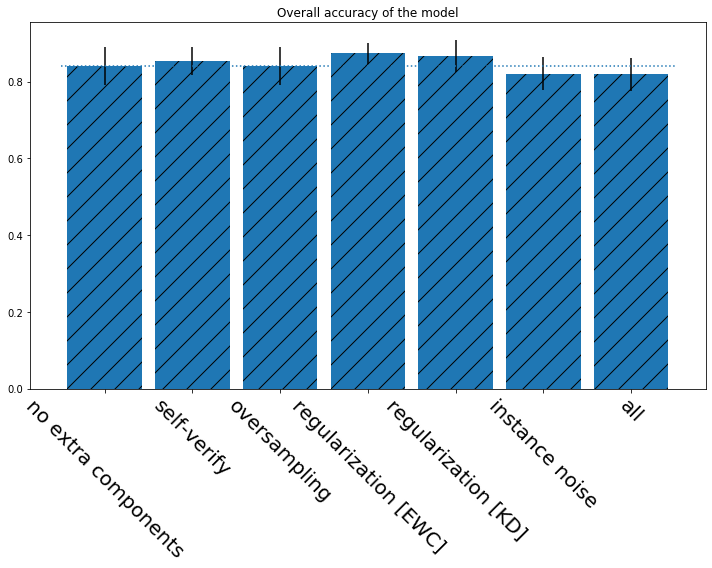

In [86]:
stability, plasticity, overallAcc = all_values["HouseA"]

models = ["sg-cgan"]
plot(stability, "Stability of the model", xticks=xticks, models=models)
plot(plasticity, "Plasticity of the model", xticks=xticks, models=models)
plot(overallAcc, "Overall accuracy of the model", xticks=xticks, models=models)

[1.8776769932952686, 2.0316891080589827, 1.8776769932952686, 1.6557987584611398, 2.5925994758815696, 1.6039069524164167, 2.1593268616635104]
[0.7545432225051488, 0.8404342452509702, 0.7545432225051488, 0.6806113212054612, 1.150965288559336, 0.5751083095291983, 0.867416976745942]


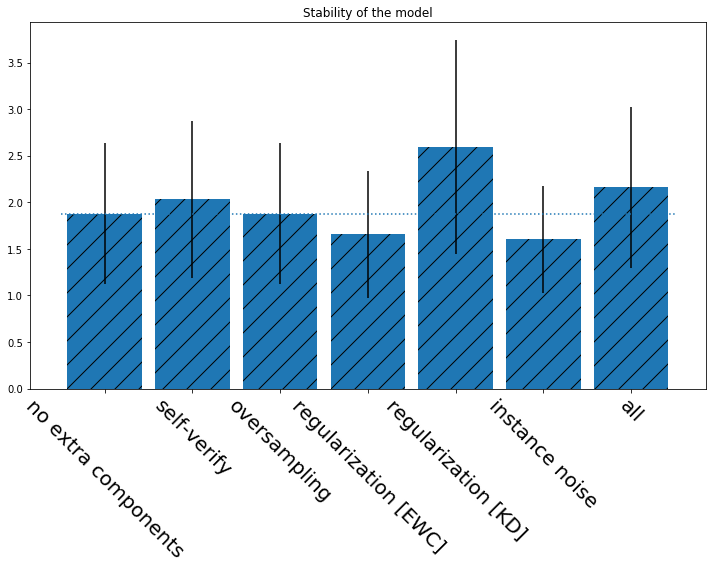

[1.7509493644838137, 1.7511465656356107, 1.7509493644838137, 1.7545081803609612, 1.5766338441374017, 1.7555310882657609, 1.602192465063399]
[0.3709944848182301, 0.37131687659204915, 0.3709944848182301, 0.3708447519321402, 0.3930907753230423, 0.37071319630235894, 0.36919370687931413]


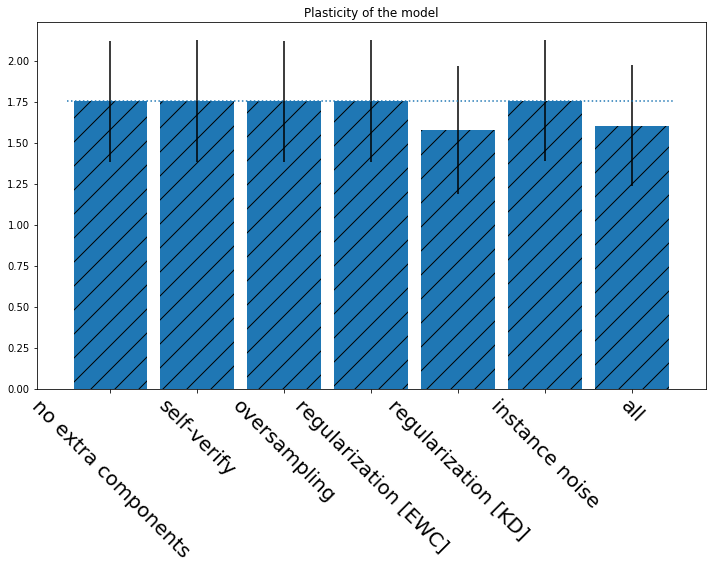

[0.7516313127774829, 0.831234831437226, 0.7516313127774829, 0.807761426138218, 0.9654253098302414, 0.8838359214016044, 1.0079209289931506]
[0.08336582443130634, 0.13127933485090013, 0.08336582443130634, 0.12191888389500675, 0.14719420195567268, 0.10027731916149606, 0.10386580208191261]


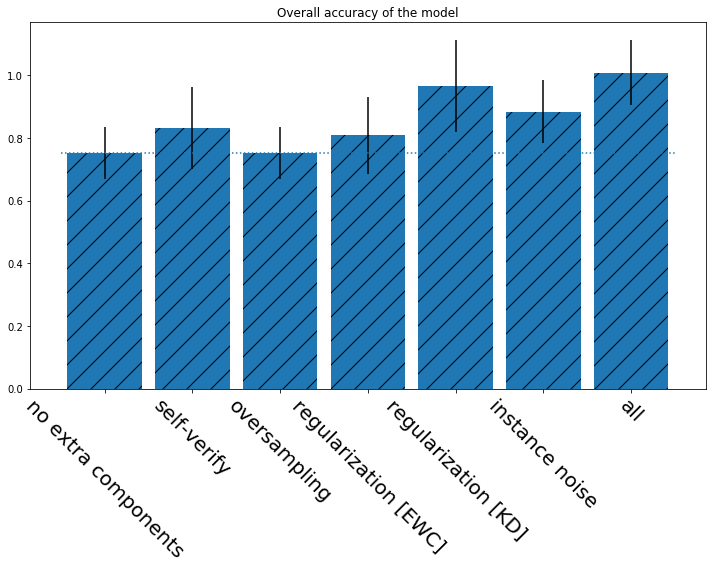

In [87]:

stability, plasticity, overallAcc = all_values["CASAS"]

models = ["sg-cgan"]
plot(stability, "Stability of the model", xticks=xticks, models=models)
plot(plasticity, "Plasticity of the model", xticks=xticks, models=models)
plot(overallAcc, "Overall accuracy of the model", xticks=xticks, models=models)

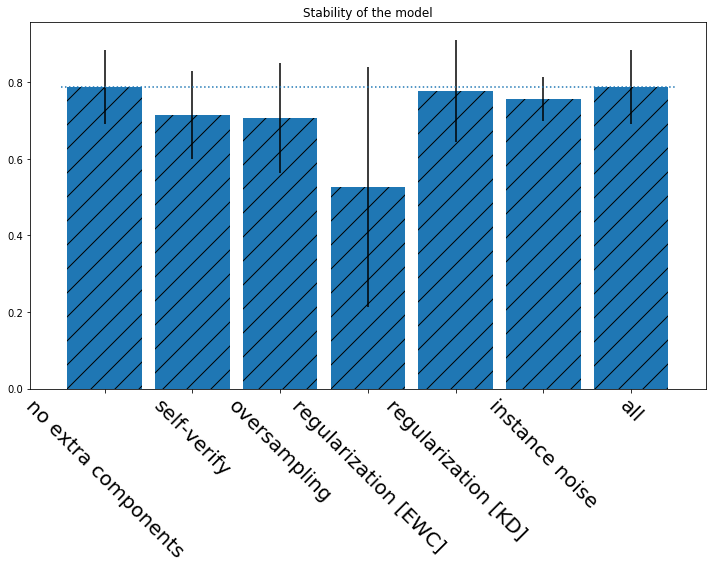

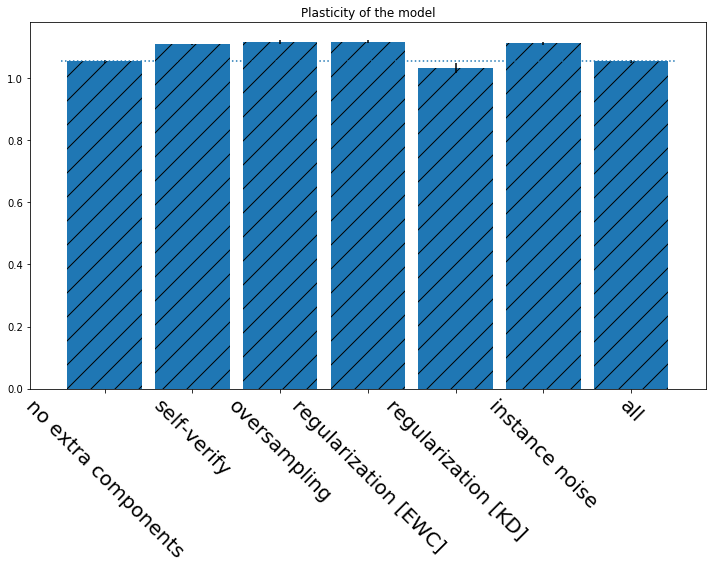

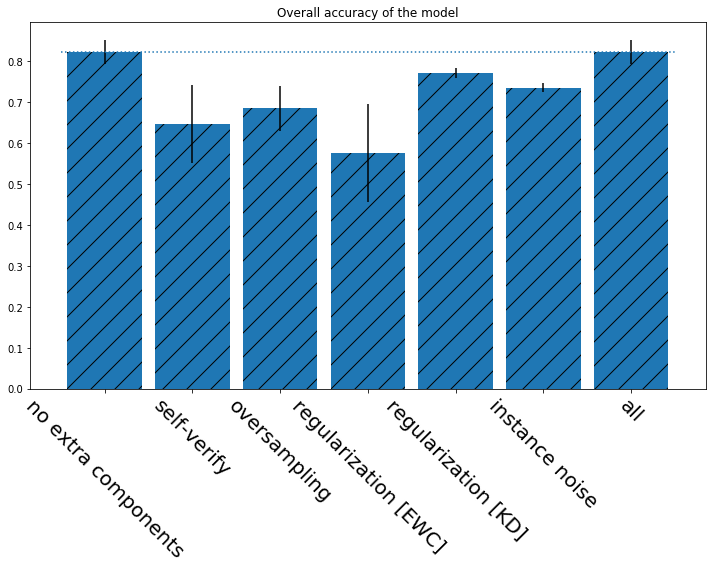

In [77]:

stability, plasticity, overallAcc = all_values["PAMAP"]

models = ["sg-cgan"]
plot(stability, "Stability of the model", xticks=xticks, models=models)
plot(plasticity, "Plasticity of the model", xticks=xticks, models=models)
plot(overallAcc, "Overall accuracy of the model", xticks=xticks, models=models)

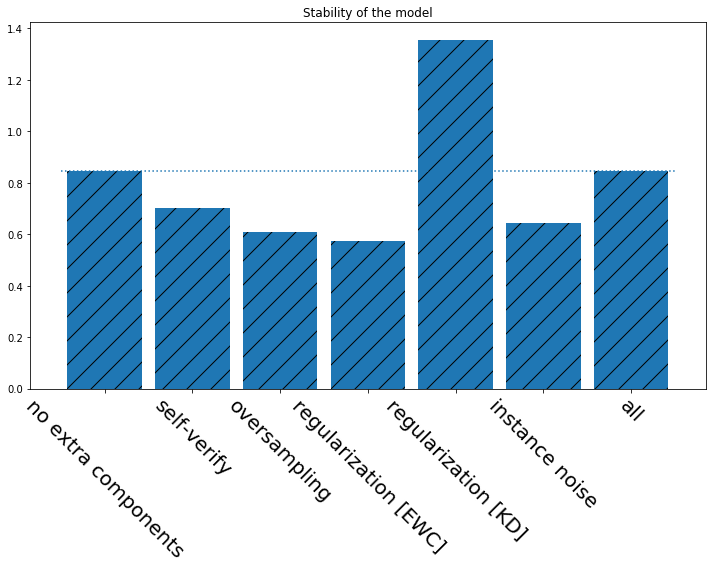

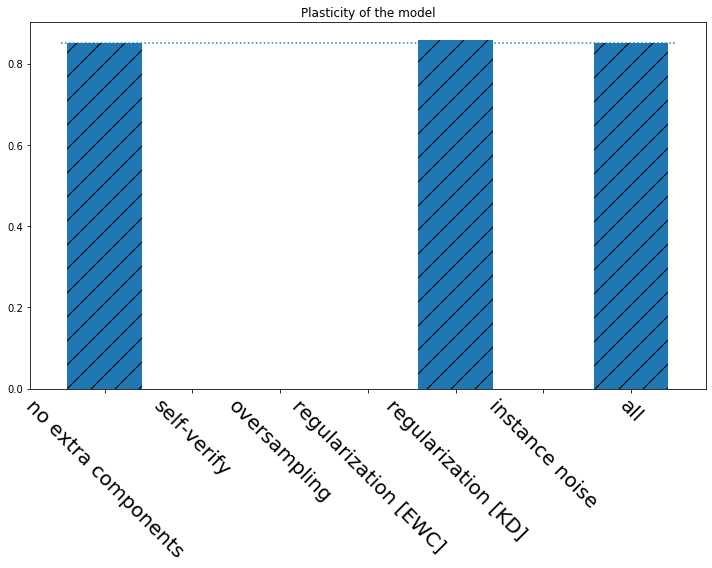

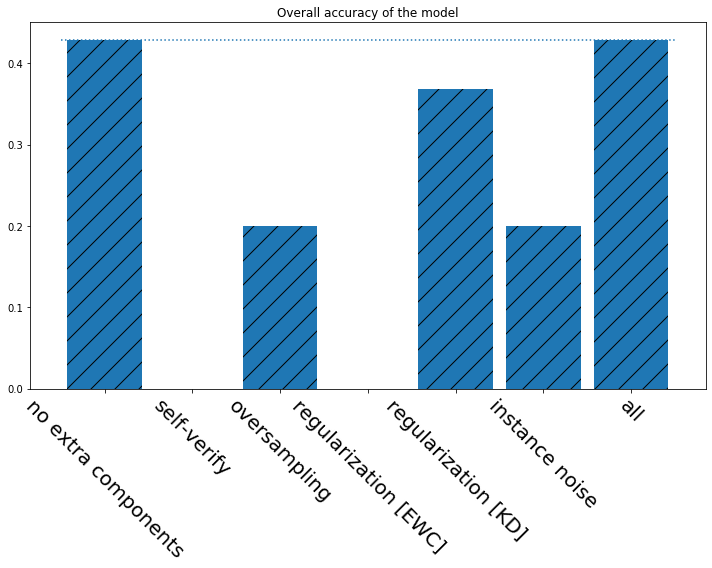

In [78]:

stability, plasticity, overallAcc = all_values["DSADS"]

models = ["sg-cgan"]
plot(stability, "Stability of the model", xticks=xticks, models=models)
plot(plasticity, "Plasticity of the model", xticks=xticks, models=models)
plot(overallAcc, "Overall accuracy of the model", xticks=xticks, models=models)